In [34]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time


In [35]:
ROOT_DIR = (Path('..')).resolve()
assert(ROOT_DIR.resolve().exists())

EXPERIMENTS_DIR = ROOT_DIR / 'experiments'
LOGS_DIR = EXPERIMENTS_DIR / 'logs'
assert(LOGS_DIR.exists()), f"Logs directory {LOGS_DIR} does not exist!"

In [36]:
def calc_ylims(ax, step=0.1):
    y_min, y_max = ax.get_ylim()
    
    y_max = np.ceil(y_max / step) * step

    ax.set_ylim(0, y_max)

In [ ]:
def plot_history(df, hide_metrics, save_folder=None):
    """
    Plots training progress live from the CSVLogger output.
    Losses are plotted together, each metric is plotted individually.
    """

    if hide_metrics is None:
        hide_metrics = []
    if not all(m in df.columns for m in hide_metrics):
        print(f"Hiding metrics: {hide_metrics}")
        print(df.columns)
        raise ValueError(f"hide_metrics contains invalid metric names: {hide_metrics}")
    
    metric_cols = set(df.columns) - {'epoch', 'train_loss', 'valid_loss', 'time'} - set(hide_metrics)
    if len(df) > 0:
        clear_output(wait=True)
        n_metrics = len(metric_cols)
        fig, axes = plt.subplots(1, 1 + n_metrics, figsize=(7*(1 + n_metrics), 5))

        if n_metrics == 0:
            axes = [axes]
        else:
            axes = np.atleast_1d(axes)

        # Plot 1: Losses
        df[['train_loss', 'valid_loss']].plot(ax=axes[0])
        axes[0].set_title('Training & Validation Loss')
        axes[0].set_xlabel('Epoch')
        # axes[0].set_yscale('log')
        axes[0].grid(True)

        # Plot each metric individually
        for i, metric in enumerate(sorted(metric_cols), start=1):
            df[metric].plot(ax=axes[i], alpha=0.5, color='tab:orange', label=exp_name+'Raw')
            df[metric].rolling(window=5, min_periods=1).mean().plot(ax=axes[i], color='tab:orange', label=exp_name+'Smoothed')
            axes[i].set_title(metric)
            axes[i].set_xlabel('Epoch')
            axes[i].grid(True)

            # Scatter new bests
            best_idxs = df[metric].cummax().diff().fillna(0) > 0
            best_epochs = df.index[best_idxs]
            axes[i].scatter(best_epochs, df.loc[best_epochs, metric], color='tab:orange', label=exp_name+'New Best', zorder=5, alpha=0.7, marker='x')
            axes[i].legend()

            # vline with text of current epoch
            current_epoch = df['epoch'].iloc[-1]
            axes[i].axvline(current_epoch, color='gray', linestyle='--', alpha=0.7)
            axes[i].text(current_epoch, axes[i].get_ylim()[1]*0.95, f'Epoch {current_epoch}', rotation=90, verticalalignment='top', color='gray')
            
            calc_ylims(axes[i], step=0.05)

        plt.tight_layout()
        if save_folder is not None:
            plt.savefig(save_folder / 'training_progress.png')

        plt.show()

In [38]:
def monitor_training(csv_path='history.csv', interval_ms=500, hide_metrics=None):
    """
    Plots training progress live from the CSVLogger output.
    Losses are plotted together, each metric is plotted individually.
    Scatter a point on each new best validation loss.
    """
    last_df = None
    while True:

        try:
            df = pd.read_csv(csv_path)
            if last_df is None or not df.equals(last_df):
                plot_history(df, hide_metrics=hide_metrics)
                
            last_df = df
            
        except FileNotFoundError:
            print("Waiting for CSVLogger to create history.csv...")
        except Exception as e:
            print(f"Error reading log: {e}")
            
        time.sleep(interval_ms / 1000)

In [39]:
# monitor_training(LOGS_DIR / 'segmentation_log.csv', hide_metrics=['dice_multi'], interval_ms=2*1000)

In [46]:
dfs = {}

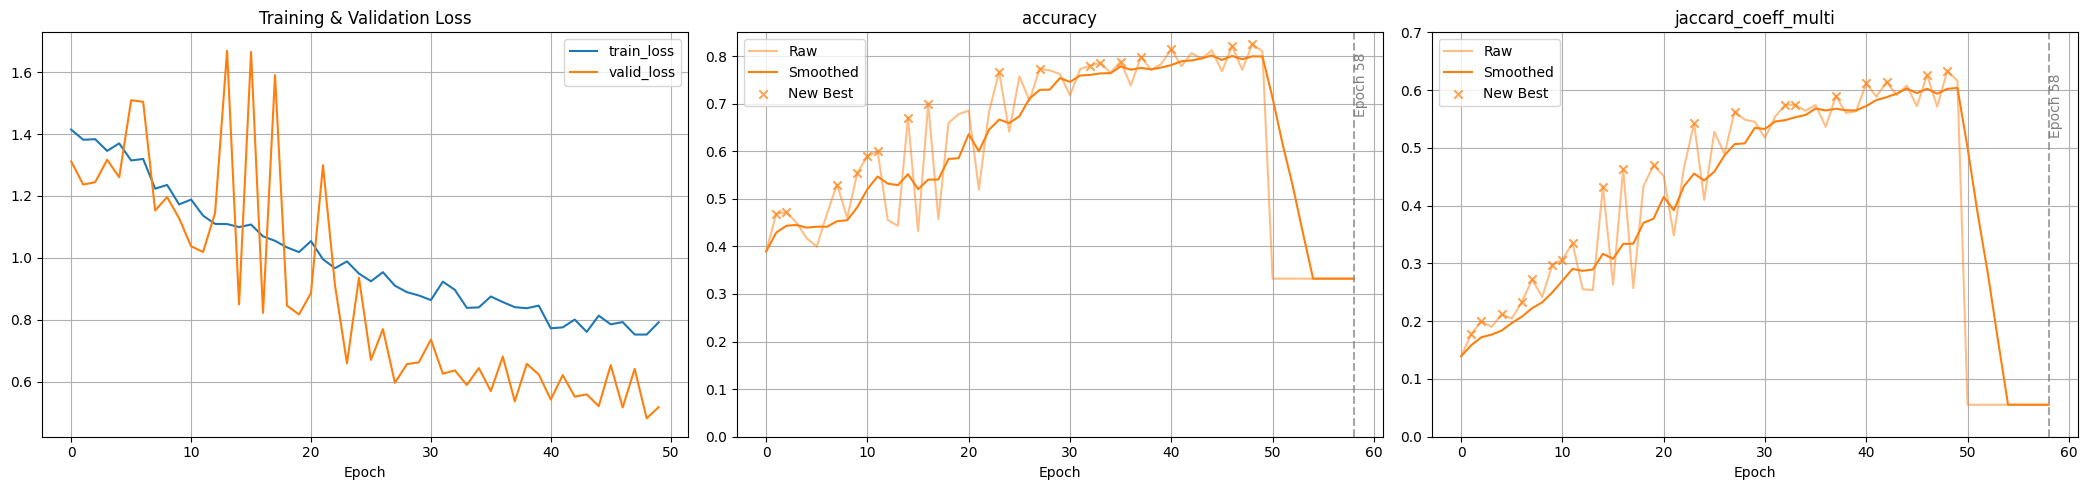

In [47]:
exp_name = 'baseline_34'
df = pd.read_csv(EXPERIMENTS_DIR / 'new-ds' / exp_name /f'{exp_name}_log.csv')
dfs[exp_name] = df
plot_history(df, hide_metrics=['dice_multi'], save_folder=EXPERIMENTS_DIR / 'new-ds' / exp_name)

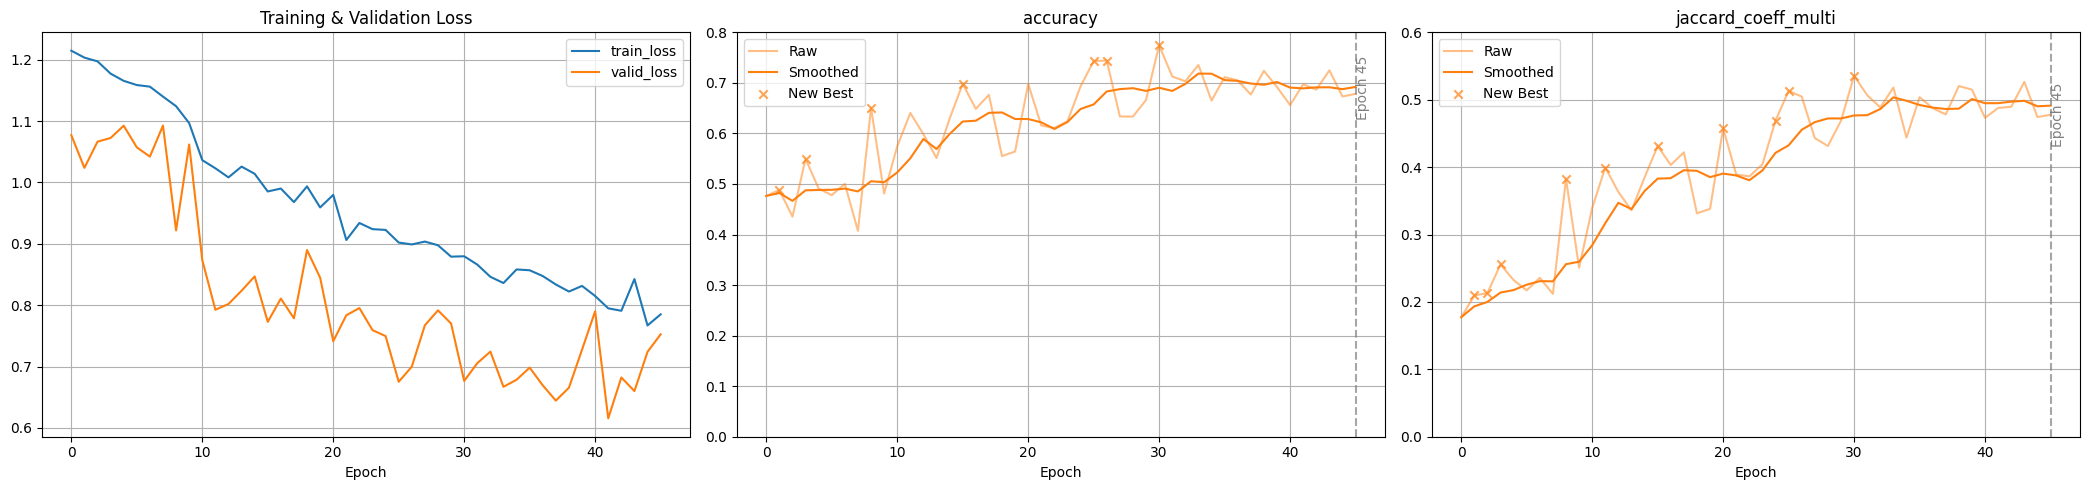

In [48]:
exp_name = 'cse_combined_loss'
df = pd.read_csv(EXPERIMENTS_DIR / 'new-ds' / exp_name / f'{exp_name}_log.csv')
dfs[exp_name] = df
plot_history(df, hide_metrics=['dice_multi'], save_folder=EXPERIMENTS_DIR / 'new-ds' / exp_name)

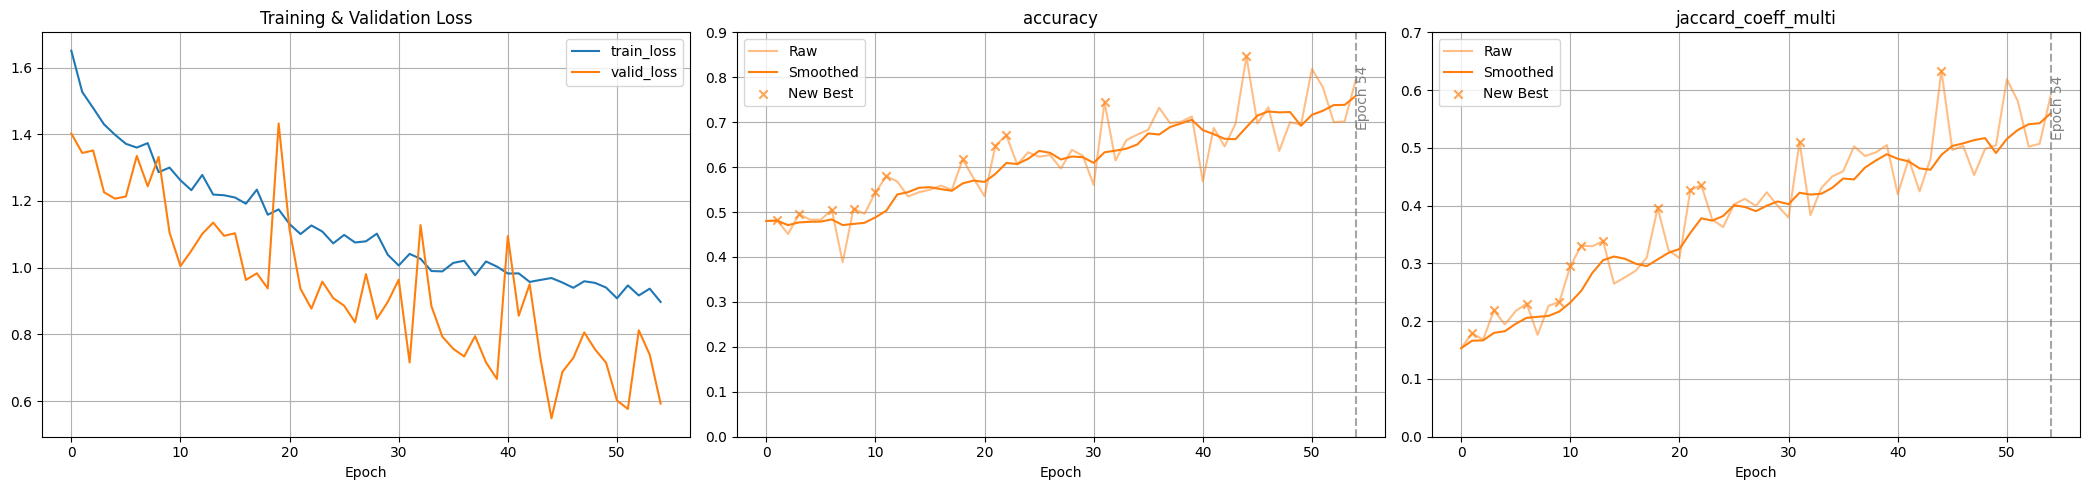

In [49]:
exp_name = 'cse'
df = pd.read_csv(EXPERIMENTS_DIR / 'new-ds' / exp_name / f'{exp_name}_log.csv')
dfs[exp_name] = df
plot_history(df, hide_metrics=['dice_multi'], save_folder=EXPERIMENTS_DIR / 'new-ds' / exp_name)

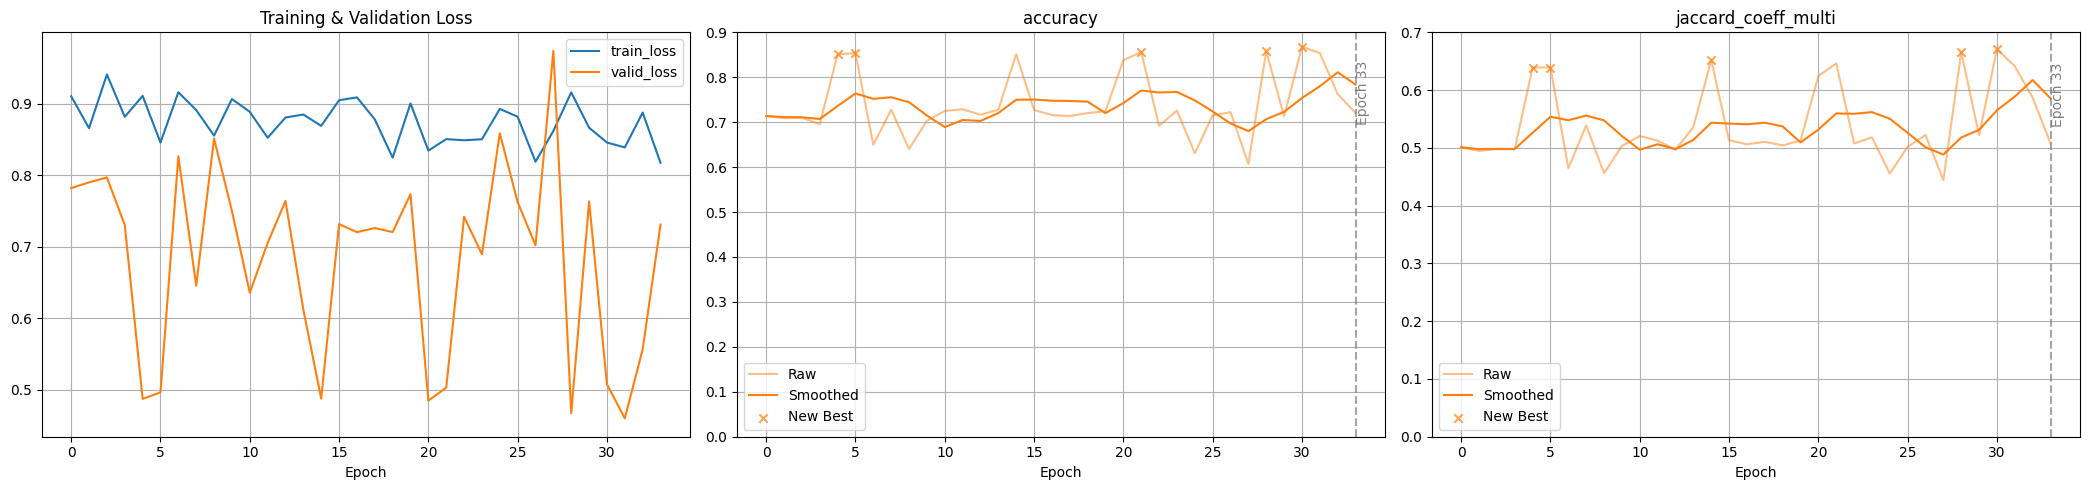

In [50]:
exp_name = 'cse_phase_2'
df = pd.read_csv(EXPERIMENTS_DIR / 'new-ds' / exp_name / f'{exp_name}_log.csv')
dfs[exp_name] = df
plot_history(df, hide_metrics=['dice_multi'], save_folder=EXPERIMENTS_DIR / 'new-ds' / exp_name)

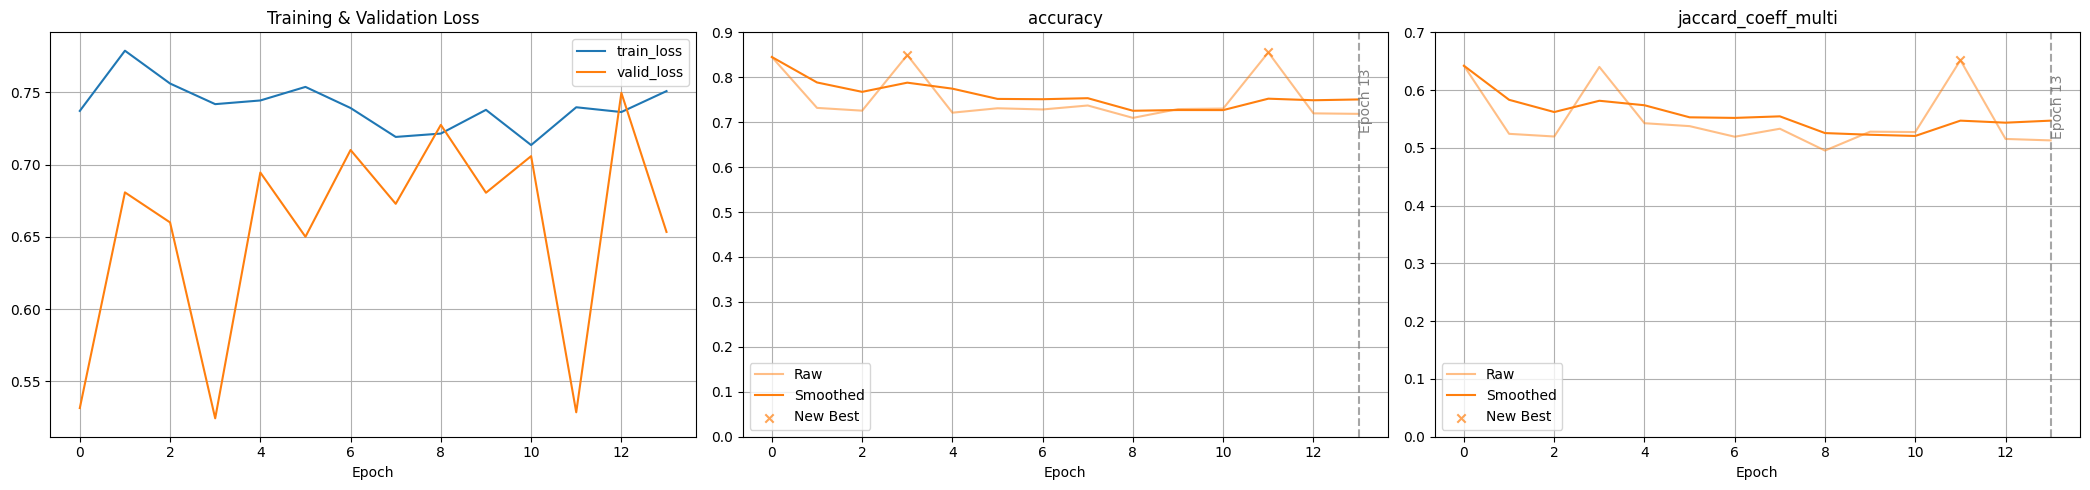

In [51]:
exp_name = 'cse_phase_3'
df = pd.read_csv(EXPERIMENTS_DIR / 'new-ds' / exp_name / f'{exp_name}_log.csv')
dfs[exp_name] = df
plot_history(df, hide_metrics=['dice_multi'], save_folder=EXPERIMENTS_DIR / 'new-ds' / exp_name)

---

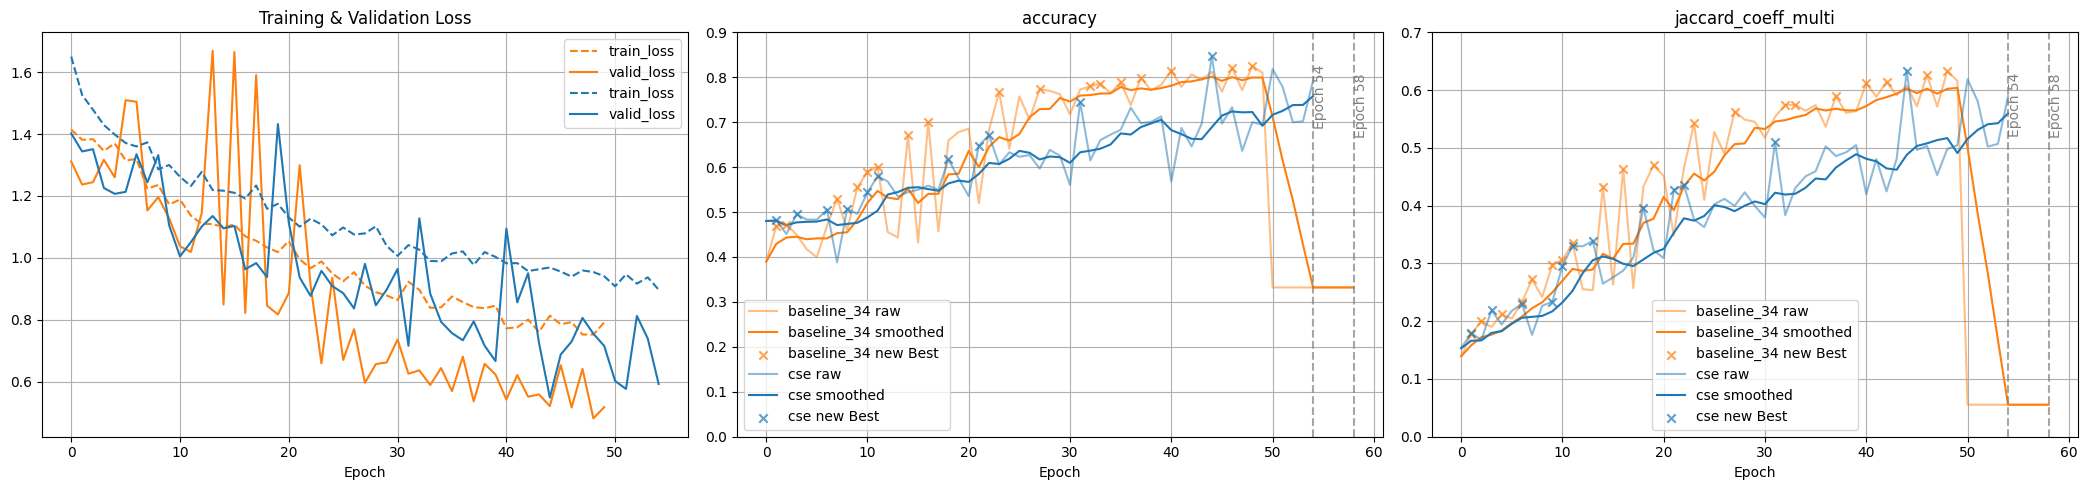

In [64]:
def plot_history_for_many(dfs, hide_metrics, save_folder=None, exp_names=None):
    """
    Plots training progress live from the CSVLogger output.
    Losses are plotted together, each metric is plotted individually.
    """

    if hide_metrics is None:
        hide_metrics = []
    if not all(m in dfs[0].columns for m in hide_metrics):
        print(f"Hiding metrics: {hide_metrics}")
        print(dfs[0].columns)
        raise ValueError(f"hide_metrics contains invalid metric names: {hide_metrics}")
    
    metric_cols = set(dfs[0].columns) - {'epoch', 'train_loss', 'valid_loss', 'time'} - set(hide_metrics)
    n_metrics = len(metric_cols)
    fig, axes = plt.subplots(1, 1 + n_metrics, figsize=(7*(1 + n_metrics), 5))
    colors = ['tab:orange', 'tab:blue', 'tab:green', 'tab:red', 'tab:purple']
    for (df, color, exp_name) in zip(dfs, colors, exp_names):
        if len(df) > 0:
            clear_output(wait=True)

            if n_metrics == 0:
                axes = [axes]
            else:
                axes = np.atleast_1d(axes)

            # Plot 1: Losses
            df[['train_loss']].plot(ax=axes[0], color=color, linestyle='--', label=exp_name+' train_loss')
            df[['valid_loss']].plot(ax=axes[0], color=color, linestyle='-', label=exp_name+' valid_loss')
            axes[0].set_title('Training & Validation Loss')
            axes[0].set_xlabel('Epoch')
            # axes[0].set_yscale('log')
            axes[0].grid(True)

            # Plot each metric individually
            for i, metric in enumerate(sorted(metric_cols), start=1):
                df[metric].plot(ax=axes[i], alpha=0.5, color=color, label=exp_name+' raw')
                df[metric].rolling(window=5, min_periods=1).mean().plot(ax=axes[i], color=color, label=exp_name+' smoothed')
                axes[i].set_title(metric)
                axes[i].set_xlabel('Epoch')
                axes[i].grid(True)

                # Scatter new bests
                best_idxs = df[metric].cummax().diff().fillna(0) > 0
                best_epochs = df.index[best_idxs]
                axes[i].scatter(best_epochs, df.loc[best_epochs, metric], color=color, label=exp_name+' new Best', zorder=5, alpha=0.7, marker='x')
                axes[i].legend()

                # vline with text of current epoch
                current_epoch = df['epoch'].iloc[-1]
                axes[i].axvline(current_epoch, color='gray', linestyle='--', alpha=0.7)
                axes[i].text(current_epoch, axes[i].get_ylim()[1]*0.95, f'Epoch {current_epoch}', rotation=90, verticalalignment='top', color='gray')

    for i in range(1, 1 + n_metrics):    
        calc_ylims(axes[i], step=0.05)

    plt.tight_layout()
    if save_folder is not None:
        plt.savefig(save_folder / 'training_progress.png')

    plt.show()

plot_history_for_many([dfs['baseline_34'], dfs['cse']], hide_metrics=['dice_multi'], exp_names=['baseline_34', 'cse'])